## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [2]:
def hists_plot(df, title=''):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    fig.suptitle(title)
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [3]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = round(equal[equal == True].sum() / len(equal), 2)
    return accuracy

In [4]:
def jaccard_dist(a,b):
    intersction =len(set(a).intersection(b))
    union = len(a) + len(b) -intersction
    return 1 - float(intersction) / union

## Read data

In [5]:
users = pd.read_csv('users.csv')

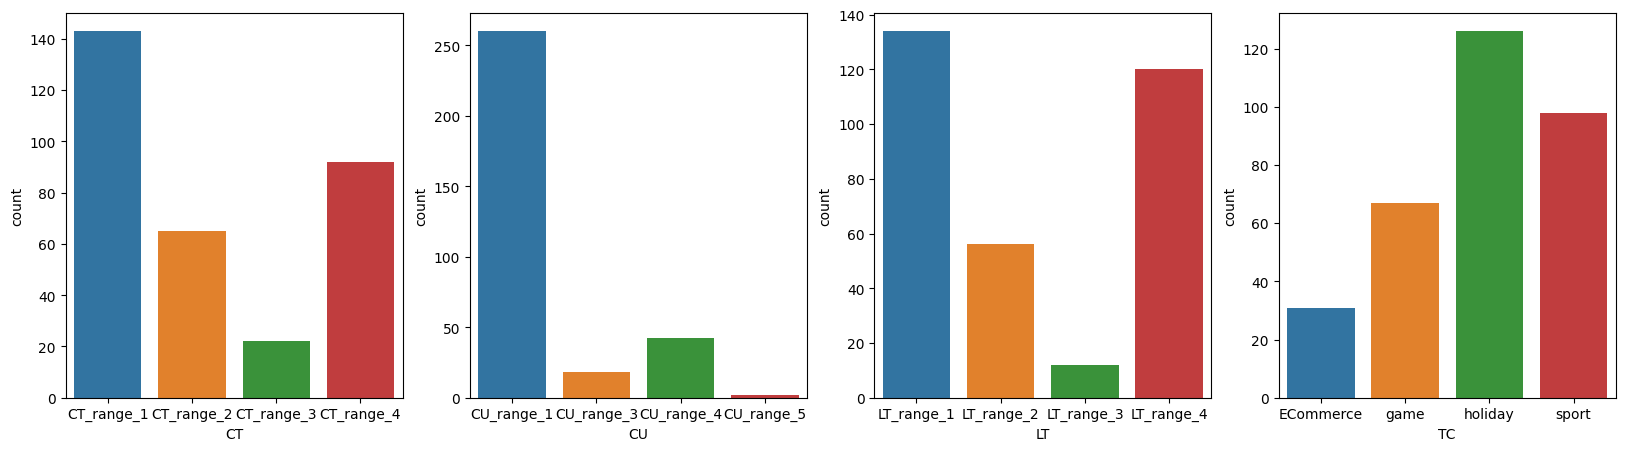

In [6]:
hists_plot(users)

## Shuffle data

In [7]:
#users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [8]:
users_dirty_all = np.array(dirty_completeness.injection(df_pandas=users, seed=1234, name = 'users', name_class="none"))

saved users-completeness50%
saved users-completeness60%
saved users-completeness70%
saved users-completeness80%
saved users-completeness90%


In [9]:
'''users_dirty = pd.DataFrame(users_dirty_all[0],columns=users.columns) #50% completeness'''

'users_dirty = pd.DataFrame(users_dirty_all[0],columns=users.columns) #50% completeness'

In [10]:
'''users_dirty'''

'users_dirty'

## Visualizing null values

In [11]:
'''sns.heatmap(users_dirty.isna())'''

'sns.heatmap(users_dirty.isna())'

## Imputation

### Simple Imputation FFILL&BFILL

In [12]:
users_simple_imp = {}
simple_accuracies = {}
for i, df_dirty in enumerate(users_dirty_all):
    users_dirty = pd.DataFrame(df_dirty, columns=users.columns)
    users_simple_imp[i] = users_dirty.fillna(method='ffill')
    users_simple_imp[i] = users_simple_imp[i].fillna(method='bfill')
    simple_accuracies[i] = accuracy(users, users_simple_imp[i])

simple_accuracies

{0: {'CT': 0.92, 'CU': 0.91, 'LT': 0.9, 'TC': 1.0},
 1: {'CT': 0.92, 'CU': 0.93, 'LT': 0.93, 'TC': 1.0},
 2: {'CT': 0.94, 'CU': 0.97, 'LT': 0.93, 'TC': 0.99},
 3: {'CT': 0.96, 'CU': 0.95, 'LT': 0.97, 'TC': 1.0},
 4: {'CT': 0.97, 'CU': 0.99, 'LT': 0.99, 'TC': 1.0}}

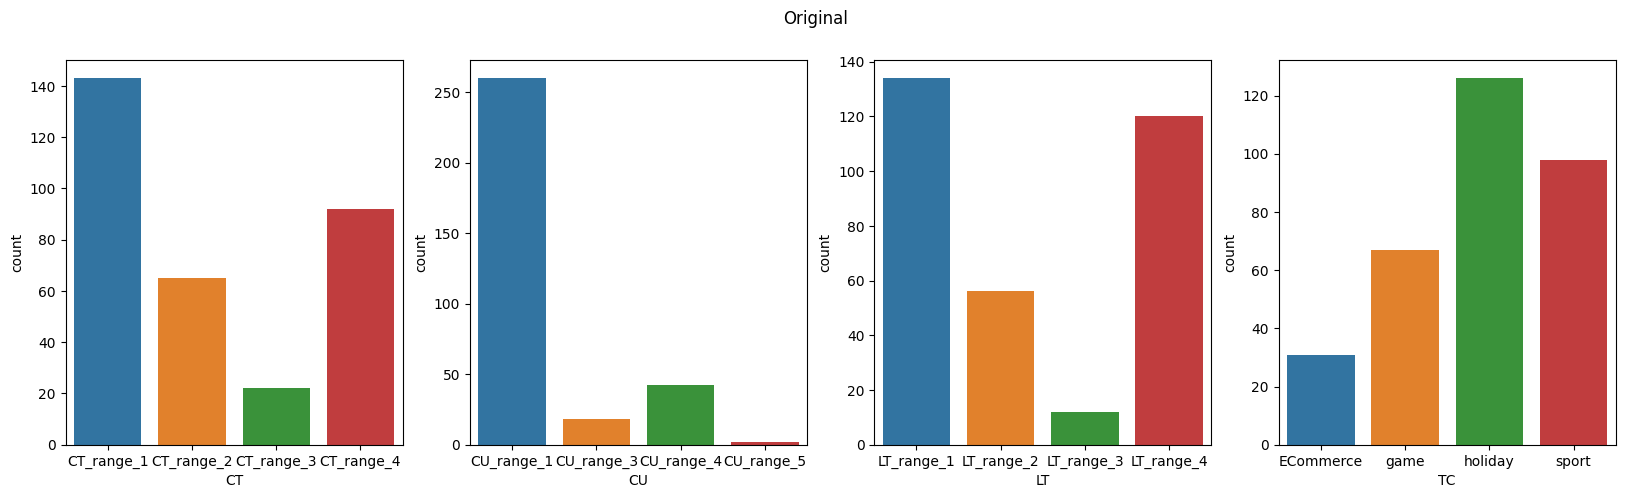

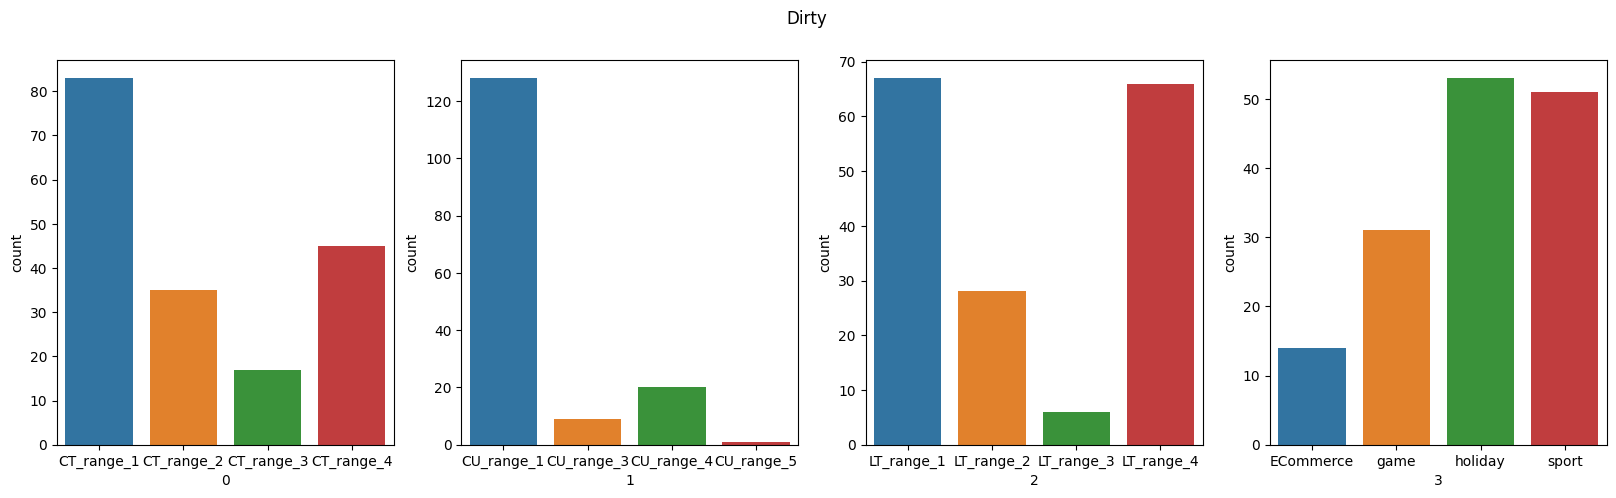

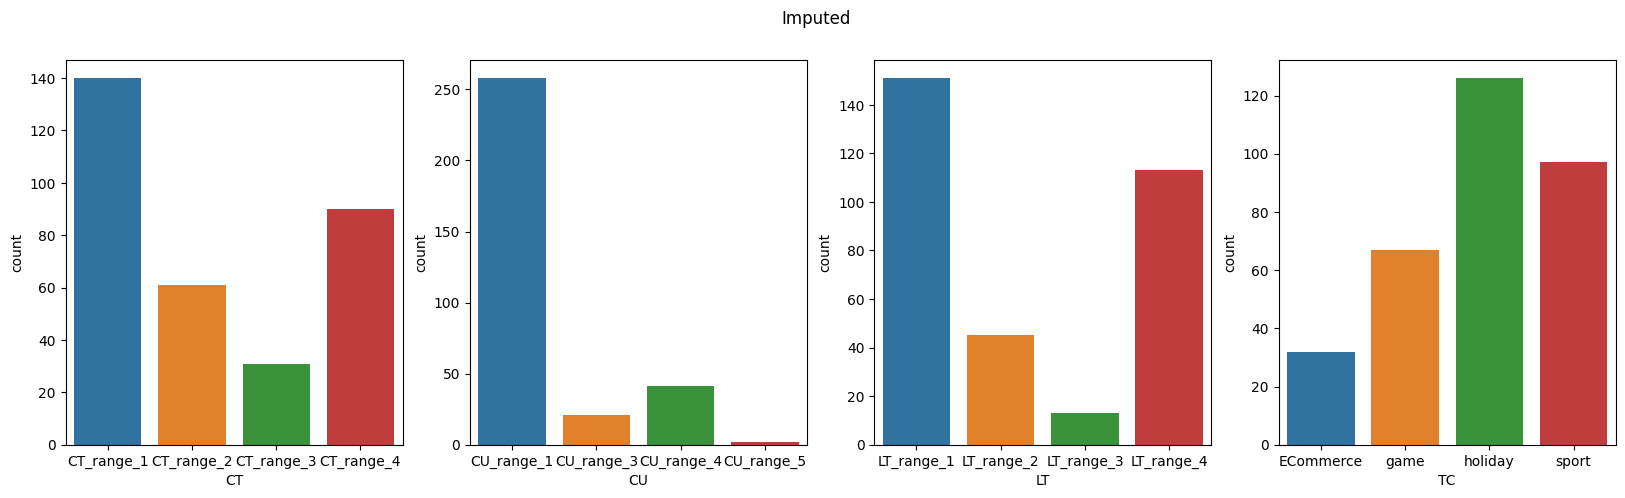

In [13]:
hists_plot(users,'Original')
hists_plot(pd.DataFrame(users_dirty_all[0]),'Dirty')
hists_plot(users_simple_imp[0],'Imputed')

### Advanced Imputation: KNN

In [14]:
from sklearn.impute import KNNImputer

In [15]:
knn_accuracies = {}
users_knn_imp = {}
for i, df_dirty in enumerate(users_dirty_all):
    users_dirty = pd.DataFrame(df_dirty, columns=users.columns)

    users_dirty_one_hot = pd.get_dummies(users_dirty)
    for col in users_dirty.columns:
        users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan
    
    knn_imputer = KNNImputer(n_neighbors=4)
    users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
    users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

    users_knn_imp[i] = pd.DataFrame()
    for col in users_dirty.columns:
        users_knn_imp[i][col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
    users_knn_imp[i] = users_knn_imp[i].apply(lambda e: e.str[3:] )
    users_knn_imp[i]
    knn_accuracies[i] = accuracy(users,users_knn_imp[i])

knn_accuracies

{0: {'CT': 0.76, 'CU': 0.9, 'LT': 0.79, 'TC': 0.8},
 1: {'CT': 0.84, 'CU': 0.92, 'LT': 0.85, 'TC': 0.87},
 2: {'CT': 0.88, 'CU': 0.96, 'LT': 0.92, 'TC': 0.91},
 3: {'CT': 0.94, 'CU': 0.97, 'LT': 0.95, 'TC': 0.94},
 4: {'CT': 0.97, 'CU': 1.0, 'LT': 0.99, 'TC': 0.98}}

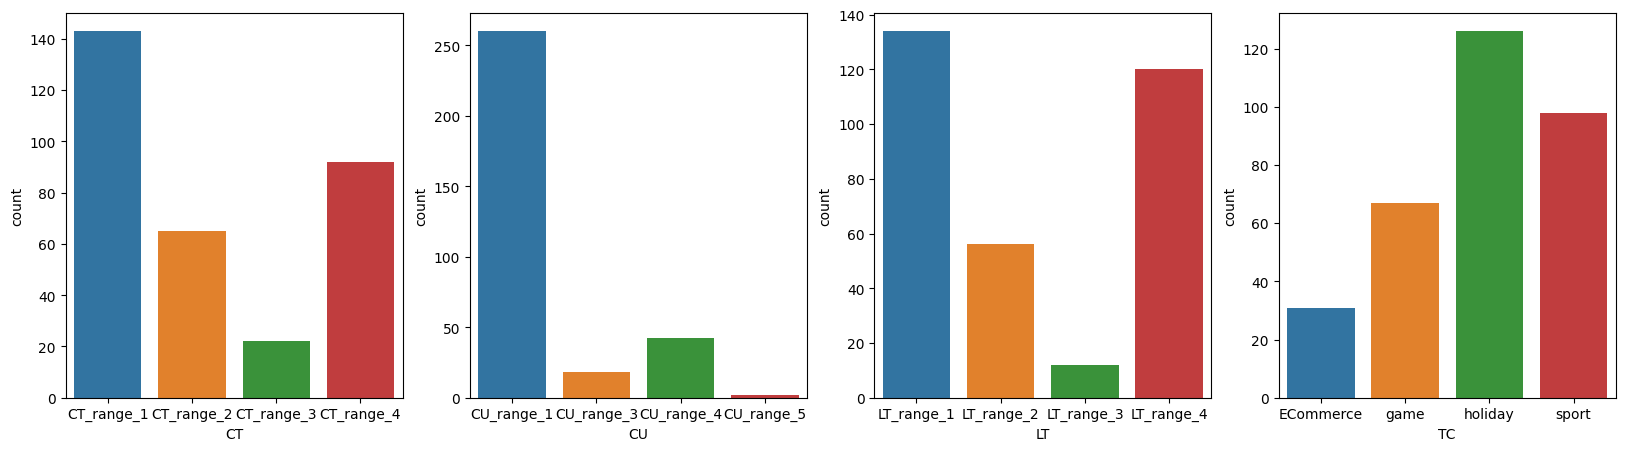

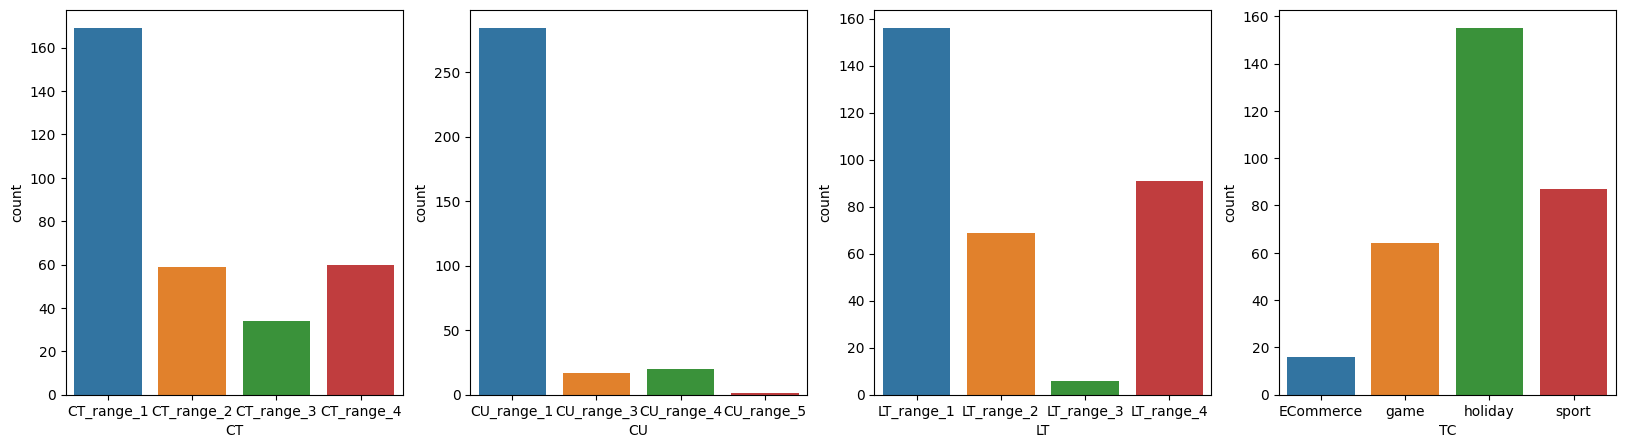

In [16]:
hists_plot(users)
hists_plot(users_knn_imp[0])

In [17]:
accuracy(users,users_knn_imp[0])

{'CT': 0.76, 'CU': 0.9, 'LT': 0.79, 'TC': 0.8}

## Clustering

### 1. K-Modes

In [18]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
from kmodes.kmodes import KModes

In [20]:
# Elbow curve to find optimal K
def elbow(df, k_max=16):
    cost = []
    K = range(1,k_max)
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)
        
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')


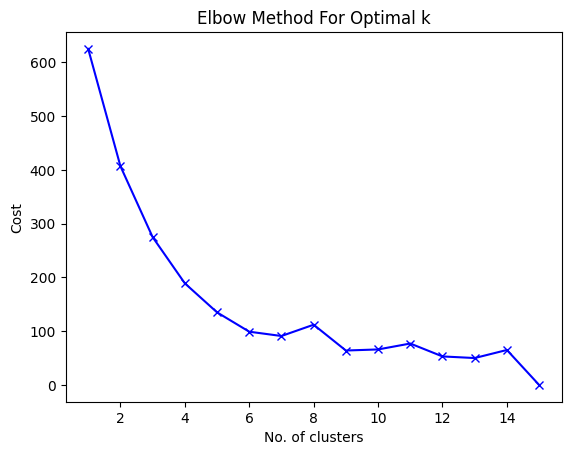

In [21]:
elbow(users)

According to the elbow plot we get the optimal number of cluster k=5

In [23]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 0)
kmodes.fit_predict(users_knn_imp[0])

array([0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 4, 2, 0, 4, 4, 4, 4, 4, 0, 0, 1, 4,
       4, 4, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0,
       0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 3, 2, 0, 4, 2, 0, 2, 2, 4, 2, 0, 0,
       3, 2, 2, 3, 0, 2, 3, 3, 2, 1, 3, 3, 2, 3, 3, 0, 1, 3, 2, 2, 2, 2,
       2, 3, 2, 3, 3, 0, 0, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2,
       3, 2, 0, 2, 2, 2, 0, 1, 3, 2, 1, 3, 2, 2, 3,

#### Cluster Personas

In [24]:
print(kmodes.cluster_centroids_)

[['CT_range_1' 'CU_range_1' 'LT_range_1' 'holiday']
 ['CT_range_2' 'CU_range_1' 'LT_range_2' 'holiday']
 ['CT_range_1' 'CU_range_1' 'LT_range_4' 'sport']
 ['CT_range_3' 'CU_range_1' 'LT_range_4' 'sport']
 ['CT_range_4' 'CU_range_1' 'LT_range_1' 'game']]


In [25]:
users_cluster_kmodes = pd.DataFrame.copy(users)
users_cluster_kmodes['Cluster'] = kmodes.labels_

In [26]:
users_cluster_kmodes

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,0
1,CT_range_1,CU_range_4,LT_range_1,ECommerce,0
2,CT_range_1,CU_range_5,LT_range_4,ECommerce,2
3,CT_range_1,CU_range_5,LT_range_4,ECommerce,0
4,CT_range_1,CU_range_4,LT_range_4,ECommerce,2
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,2
318,CT_range_3,CU_range_1,LT_range_4,sport,3
319,CT_range_1,CU_range_3,LT_range_4,sport,2
320,CT_range_2,CU_range_1,LT_range_4,sport,2


### 2. Agglomerative Hierarchical Clustering

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

#### Compute the distance matrix using Jaccard Distance

In [28]:
dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in users.iterrows()] for _,a in users.iterrows()])

In [29]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.000000,1.000000,0.857143,0.857143,0.857143,1.000000,0.857143,1.000000,0.857143,1.000000,...,0.666667,0.400000,0.400000,0.666667,0.666667,0.400000,0.400000,0.666667,0.400000,0.400000
1,1.000000,0.000000,0.666667,0.666667,0.400000,0.000000,0.400000,0.000000,0.400000,0.000000,...,0.666667,1.000000,1.000000,0.857143,0.666667,1.000000,1.000000,0.857143,1.000000,1.000000
2,0.857143,0.666667,0.000000,0.000000,0.400000,0.666667,0.400000,0.666667,0.400000,0.666667,...,0.666667,0.857143,0.857143,0.666667,0.666667,0.857143,0.857143,0.666667,0.857143,0.857143
3,0.857143,0.666667,0.000000,0.000000,0.400000,0.666667,0.400000,0.666667,0.400000,0.666667,...,0.666667,0.857143,0.857143,0.666667,0.666667,0.857143,0.857143,0.666667,0.857143,0.857143
4,0.857143,0.400000,0.400000,0.400000,0.000000,0.400000,0.000000,0.400000,0.000000,0.400000,...,0.400000,0.857143,0.857143,0.666667,0.400000,0.857143,0.857143,0.666667,0.857143,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.400000,1.000000,0.857143,0.857143,0.857143,1.000000,0.857143,1.000000,0.857143,1.000000,...,0.666667,0.000000,0.400000,0.666667,0.666667,0.000000,0.400000,0.666667,0.000000,0.400000
318,0.400000,1.000000,0.857143,0.857143,0.857143,1.000000,0.857143,1.000000,0.857143,1.000000,...,0.666667,0.400000,0.000000,0.666667,0.666667,0.400000,0.000000,0.666667,0.400000,0.000000
319,0.666667,0.857143,0.666667,0.666667,0.666667,0.857143,0.666667,0.857143,0.666667,0.857143,...,0.400000,0.666667,0.666667,0.000000,0.400000,0.666667,0.666667,0.000000,0.666667,0.666667
320,0.400000,1.000000,0.857143,0.857143,0.857143,1.000000,0.857143,1.000000,0.857143,1.000000,...,0.666667,0.000000,0.400000,0.666667,0.666667,0.000000,0.400000,0.666667,0.000000,0.400000


#### Perform the Agglomerative Clustering

In [30]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(20,5))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [31]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',linkage='complete').fit(dist_matrix)

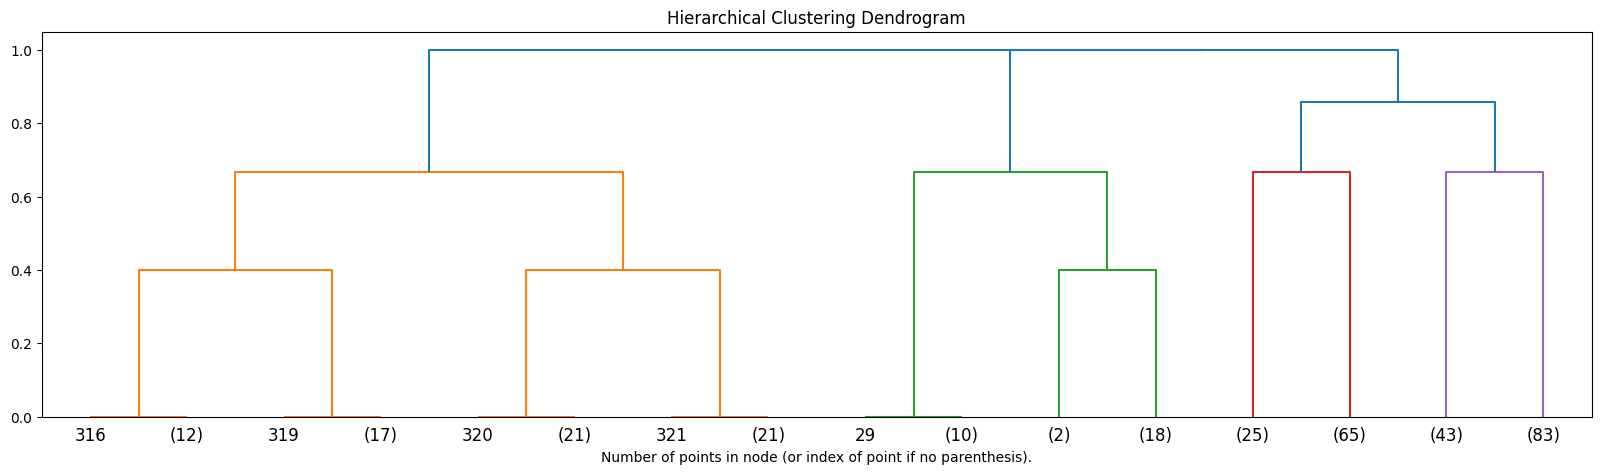

In [32]:
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [33]:
agglomerative = AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='complete').fit(dist_matrix)


In [34]:
users_cluster_agglomerative = pd.DataFrame.copy(users)
users_cluster_agglomerative['Cluster'] = agglomerative.labels_
users_cluster_agglomerative

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,0
1,CT_range_1,CU_range_4,LT_range_1,ECommerce,2
2,CT_range_1,CU_range_5,LT_range_4,ECommerce,2
3,CT_range_1,CU_range_5,LT_range_4,ECommerce,2
4,CT_range_1,CU_range_4,LT_range_4,ECommerce,2
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,1
318,CT_range_3,CU_range_1,LT_range_4,sport,1
319,CT_range_1,CU_range_3,LT_range_4,sport,1
320,CT_range_2,CU_range_1,LT_range_4,sport,1


#### Cluster Personas

In [35]:
users_cluster_agglomerative.groupby(['Cluster']).agg(pd.Series.mode)

,CT,CU,LT,TC
Cluster,,,,
0,CT_range_4,CU_range_1,LT_range_1,game
1,CT_range_1,CU_range_1,LT_range_4,sport
2,CT_range_1,CU_range_4,LT_range_4,ECommerce
3,CT_range_1,CU_range_1,LT_range_1,holiday
4,CT_range_2,CU_range_1,LT_range_2,holiday


In [36]:
silhouette_score(dist_matrix, agglomerative.labels_)

0.6500433761523676

In [37]:
clusterss = users.groupby(['CT','CU','LT','TC']).size().reset_index(name='Count')#.iloc[:,:-1]
clusterss

,CT,CU,LT,TC,Count
0,CT_range_1,CU_range_1,LT_range_1,holiday,81
1,CT_range_1,CU_range_3,LT_range_4,sport,18
2,CT_range_1,CU_range_4,LT_range_1,ECommerce,11
3,CT_range_1,CU_range_4,LT_range_4,ECommerce,18
4,CT_range_1,CU_range_4,LT_range_4,sport,13
5,CT_range_1,CU_range_5,LT_range_4,ECommerce,2
6,CT_range_2,CU_range_1,LT_range_2,holiday,43
7,CT_range_2,CU_range_1,LT_range_4,sport,22
8,CT_range_3,CU_range_1,LT_range_4,sport,22
9,CT_range_4,CU_range_1,LT_range_1,game,40


In [38]:
dist_matrix2 = np.asarray( [[jaccard_dist(a,b) for _,b in clusterss.iterrows()] for _,a in clusterss.iterrows()])

In [39]:
pd.DataFrame(dist_matrix2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.888889,0.750000,0.888889,0.888889,0.888889,0.750000,0.888889,0.888889,0.750000,0.571429,0.888889,0.888889,0.888889,0.888889
1,0.888889,0.000000,0.888889,0.571429,0.571429,0.750000,1.000000,0.750000,0.750000,1.000000,1.000000,1.000000,1.000000,0.888889,0.750000
2,0.750000,0.888889,0.000000,0.571429,0.750000,0.750000,1.000000,1.000000,1.000000,0.888889,0.888889,1.000000,1.000000,1.000000,1.000000
3,0.888889,0.571429,0.571429,0.000000,0.571429,0.571429,1.000000,0.888889,0.888889,1.000000,1.000000,1.000000,1.000000,0.888889,0.888889
4,0.888889,0.571429,0.750000,0.571429,0.000000,0.750000,1.000000,0.750000,0.750000,1.000000,1.000000,0.888889,1.000000,0.888889,0.750000
5,0.888889,0.750000,0.750000,0.571429,0.750000,0.000000,1.000000,0.888889,0.888889,1.000000,0.888889,1.000000,1.000000,0.750000,0.888889
6,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.750000,0.888889,0.888889,0.750000,0.750000,0.888889,0.888889,0.888889
7,0.888889,0.750000,1.000000,0.888889,0.750000,0.888889,0.750000,0.000000,0.333333,0.888889,0.888889,0.888889,0.888889,0.750000,0.571429
8,0.888889,0.750000,1.000000,0.888889,0.750000,0.888889,0.888889,0.333333,0.000000,0.888889,0.888889,0.888889,0.888889,0.750000,0.571429
9,0.750000,1.000000,0.888889,1.000000,1.000000,1.000000,0.888889,0.888889,0.888889,0.000000,0.571429,0.571429,0.571429,0.571429,0.750000


In [40]:
%pip install gower

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [41]:
import gower
from sklearn.cluster import KMeans

In [42]:
distance_matrix = gower.gower_matrix(users)

In [43]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.00,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,...,0.50,0.25,0.25,0.50,0.50,0.25,0.25,0.50,0.25,0.25
1,1.00,0.00,0.50,0.50,0.25,0.00,0.25,0.00,0.25,0.00,...,0.50,1.00,1.00,0.75,0.50,1.00,1.00,0.75,1.00,1.00
2,0.75,0.50,0.00,0.00,0.25,0.50,0.25,0.50,0.25,0.50,...,0.50,0.75,0.75,0.50,0.50,0.75,0.75,0.50,0.75,0.75
3,0.75,0.50,0.00,0.00,0.25,0.50,0.25,0.50,0.25,0.50,...,0.50,0.75,0.75,0.50,0.50,0.75,0.75,0.50,0.75,0.75
4,0.75,0.25,0.25,0.25,0.00,0.25,0.00,0.25,0.00,0.25,...,0.25,0.75,0.75,0.50,0.25,0.75,0.75,0.50,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.25,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,...,0.50,0.00,0.25,0.50,0.50,0.00,0.25,0.50,0.00,0.25
318,0.25,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,...,0.50,0.25,0.00,0.50,0.50,0.25,0.00,0.50,0.25,0.00
319,0.50,0.75,0.50,0.50,0.50,0.75,0.50,0.75,0.50,0.75,...,0.25,0.50,0.50,0.00,0.25,0.50,0.50,0.00,0.50,0.50
320,0.25,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,...,0.50,0.00,0.25,0.50,0.50,0.00,0.25,0.50,0.00,0.25


In [44]:
kmeans_clust = KMeans(5).fit(distance_matrix)

In [45]:
userKmeans = pd.DataFrame.copy(users)

In [46]:
userKmeans['Cluster'] = kmeans_clust.labels_

In [47]:
userKmeans

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,3
1,CT_range_1,CU_range_4,LT_range_1,ECommerce,1
2,CT_range_1,CU_range_5,LT_range_4,ECommerce,1
3,CT_range_1,CU_range_5,LT_range_4,ECommerce,1
4,CT_range_1,CU_range_4,LT_range_4,ECommerce,1
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,3
318,CT_range_3,CU_range_1,LT_range_4,sport,3
319,CT_range_1,CU_range_3,LT_range_4,sport,1
320,CT_range_2,CU_range_1,LT_range_4,sport,3


In [48]:
silhouette_score(distance_matrix, kmeans_clust.labels_, metric='precomputed')

0.75953615